**Лабораторная работа №7. Рекуррентные нейронные сети для анализа текста**


**Данные:** Набор данных для предсказания оценок для отзывов, собранных с сайта imdb.com, который состоит из 50,000 отзывов в виде текстовых файлов. Отзывы разделены на положительные (25,000) и отрицательные (25,000). Данные предварительно токенизированы по принципу “мешка слов”, индексы слов можно взять из словаря (imdb.vocab). Обучающая выборка включает в себя 12,500 положительных и 12,500 отрицательных отзывов, контрольная выборка также содержит 12,500 положительных и 12,500 отрицательных отзывов, а также. Данные можно скачать по ссылке https://ai.stanford.edu/~amaas/data/sentiment/


In [0]:
!pip install git+https://github.com/d2l-ai/d2l-en # installing d2l
!pip install -U --pre mxnet-cu101mkl  # updating mxnet to at least v1.6


  Cloning https://github.com/d2l-ai/d2l-en to /tmp/pip-req-build-b7g_6gbm
  Running command git clone -q https://github.com/d2l-ai/d2l-en /tmp/pip-req-build-b7g_6gbm
     |████████████████████████████████| 1.1MB 41.9MB/s 
  Created wheel for d2l: filename=d2l-0.11.4-cp36-none-any.whl size=31941 sha256=1a1adde51e5c072097a743b85bc837da0ddf53872805f81c74eb7b5c8294b0da
  Stored in directory: /tmp/pip-ephem-wheel-cache-r2p5xbj4/wheels/82/6f/b8/8422c7ed664272685e3d139b127f89df39d934704a14b2156c
Successfully built d2l
  Found existing installation: pyzmq 17.0.0
    Uninstalling pyzmq-17.0.0:
      Successfully uninstalled pyzmq-17.0.0


     |████████████████████████████████| 711.0MB 24kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [0]:
import shutil
from google.colab import drive
import d2l
from mxnet import gluon, np, npx, init
import os
from mxnet.gluon import nn, rnn
from mxnet.contrib import text
npx.set_np()

**Задание 1.**
Загрузите данные. Преобразуйте текстовые файлы во внутренние структуры данных, которые используют индексы вместо слов.

In [0]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
drive.mount('/content/drive')
shutil.unpack_archive("aclImdb_v1.tar.gz", "/content/aclImdb_v1/")

--2020-04-03 17:29:45--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.2’

aclImdb_v1.tar.gz.2 100%[===================>]  80.23M  85.2MB/s    in 0.9s    

2020-04-03 17:29:46 (85.2 MB/s) - ‘aclImdb_v1.tar.gz.2’ saved [84125825/84125825]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def read_imdb(data_dir, is_train):
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test',
                                   label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels

train_data = read_imdb('/content/aclImdb_v1/aclImdb', is_train=True)
print('trainings:', len(train_data[0]))

trainings: 25000


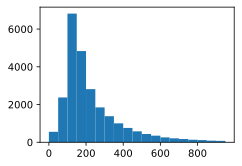

In [0]:
train_tokens = d2l.tokenize(train_data[0], token='word')
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

d2l.set_figsize((3.5, 2.5))
d2l.plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50))

In [0]:
num_steps = 500  # sequence length
train_features = np.array([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
train_features.shape

(25000, 500)

In [0]:
train_iter = d2l.load_array((train_features, train_data[1]), 64)
'batches:', len(train_iter)

('batches:', 391)

In [0]:
def load_data_imdb(batch_size, num_steps=500):
    data_dir = '/content/aclImdb_v1/aclImdb'
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    train_features = np.array([d2l.truncate_pad(
        vocab[line], num_steps, vocab.unk) for line in train_tokens])
    test_features = np.array([d2l.truncate_pad(
        vocab[line], num_steps, vocab.unk) for line in test_tokens])
    train_iter = d2l.load_array((train_features, train_data[1]), batch_size)
    test_iter = d2l.load_array((test_features, test_data[1]), batch_size,
                               is_train=False)
    return train_iter, test_iter, vocab


**Задание 2.**
Реализуйте и обучите двунаправленную рекуррентную сеть (LSTM или GRU). Какого качества классификации удалось достичь?


In [0]:
batch_size = 64
train_iter, test_iter, vocab = load_data_imdb(batch_size)

In [0]:
class BiRNN(nn.Block):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.encoder = rnn.LSTM(num_hiddens, num_layers=num_layers,
                                bidirectional=True, input_size=embed_size)
        self.decoder = nn.Dense(2)

    def forward(self, inputs):
        embeddings = self.embedding(inputs.T)
        outputs = self.encoder(embeddings)
        encoding = np.concatenate((outputs[0], outputs[-1]), axis=1)
        outs = self.decoder(encoding)
        return outs

In [0]:
embed_size, num_hiddens, num_layers, ctx = 100, 100, 2, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)
net.initialize(init.Xavier(), ctx=ctx)

loss 0.095, train acc 0.970, test acc 0.823
580.3 examples/sec on [gpu(0)]


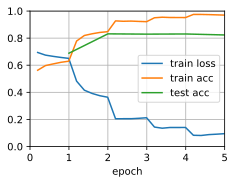

In [0]:
lr, num_epochs = 0.01, 5
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
loss = gluon.loss.SoftmaxCrossEntropyLoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, ctx)

In [0]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [0]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

**Задание 3.**
Используйте индексы слов и их различное внутреннее представление (word2vec, glove). Как влияет данное преобразование на качество классификации?


In [0]:
glove_embedding = text.embedding.create('glove', pretrained_file_name='glove.6B.100d.txt')

In [0]:
embeds = glove_embedding.get_vecs_by_tokens(vocab.idx_to_token).as_np_ndarray()
embeds.shape

(49339, 100)

In [0]:
net.embedding.weight.set_data(embeds)
net.embedding.collect_params().setattr('grad_req', 'null')

loss 0.317, train acc 0.866, test acc 0.844
604.6 examples/sec on [gpu(0)]


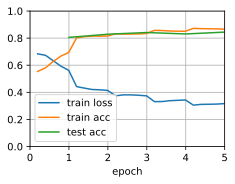

In [0]:
lr, num_epochs = 0.01, 5
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
loss = gluon.loss.SoftmaxCrossEntropyLoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, ctx)

In [0]:
def predict_sentiment(net, vocab, sentence):
    sentence = np.array(vocab[sentence.split()], ctx=d2l.try_gpu())
    label = np.argmax(net(sentence.reshape(1, -1)), axis=1)
    return 'positive' if label == 1 else 'negative'

In [0]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [0]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

**Задание 4.**
Поэкспериментируйте со структурой сети (добавьте больше рекуррентных, полносвязных или сверточных слоев). Как это повлияло на качество классификации?


In [0]:
embed_size, num_hiddens, num_layers, ctx = 100, 100, 4, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)
net.initialize(init.Xavier(), ctx=ctx)

loss 0.075, train acc 0.975, test acc 0.840
265.2 examples/sec on [gpu(0)]


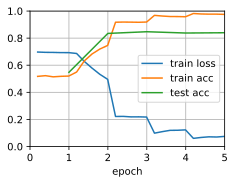

In [0]:
lr, num_epochs = 0.01, 5
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
loss = gluon.loss.SoftmaxCrossEntropyLoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, ctx)

**Задание 5.**
Используйте предобученную рекуррентную нейронную сеть (например, DeepMoji или что-то подобное).
Какой максимальный результат удалось получить на контрольной выборке?



In [0]:
# model = tf.keras.models.load_model('my_model.h5'

In [2]:
!git clone https://github.com/bfelbo/DeepMoji.git

Cloning into 'DeepMoji'...
remote: Enumerating objects: 281, done.
remote: Total 281 (delta 0), reused 0 (delta 0), pack-reused 281
Receiving objects: 100% (281/281), 110.54 MiB | 28.08 MiB/s, done.
Resolving deltas: 100% (142/142), done.
Checking out files: 100% (66/66), done.


In [17]:
!pip install tensorflow==1.14

     |████████████████████████████████| 109.2MB 97kB/s 
     |████████████████████████████████| 3.2MB 49.4MB/s 
     |████████████████████████████████| 491kB 56.5MB/s 
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc2


In [0]:
import os 
os.chdir('/content/DeepMoji')

In [3]:
from __future__ import print_function
import deepmoji
import examples.example_helper
import numpy as np
from keras.preprocessing import sequence
from keras.datasets import imdb
import deepmoji.model_def

nb_tokens = 20000
maxlen = 80
batch_size = 32

print('Loading data...')
print(len(train_data[0]), 'train sequences')
print(len(test_data[0]), 'test sequences')
print('Pad sequences (samples x time)')
print('X_train shape:', train_data.shape)
print('X_test shape:', test_data.shape)

print('Build model...')
model = deepmoji.model_def.deepmoji_architecture(nb_classes=2, nb_tokens=nb_tokens, maxlen=maxlen)
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(train_data[0], train_data[1], batch_size=batch_size, epochs=5,
          validation_data=(test_data[0], test_data[0]))
score, acc = model.evaluate(test_data[0], test_data[1], batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
X_train shape: (25000, 80)
X_test shape: (25000, 80)
Build model...
Model: "DeepMoji"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 80)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 256)      5120000     input_2[0][0]                    
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 80, 256)      0           embedding[0][0]                  
__________________________________________________________________________________________________
bi_lstm_0 (Bidirectional)       